# Constant Velocity #

In [6]:
from route_generation import *
from visual_tools import *
import evaluation_tools
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


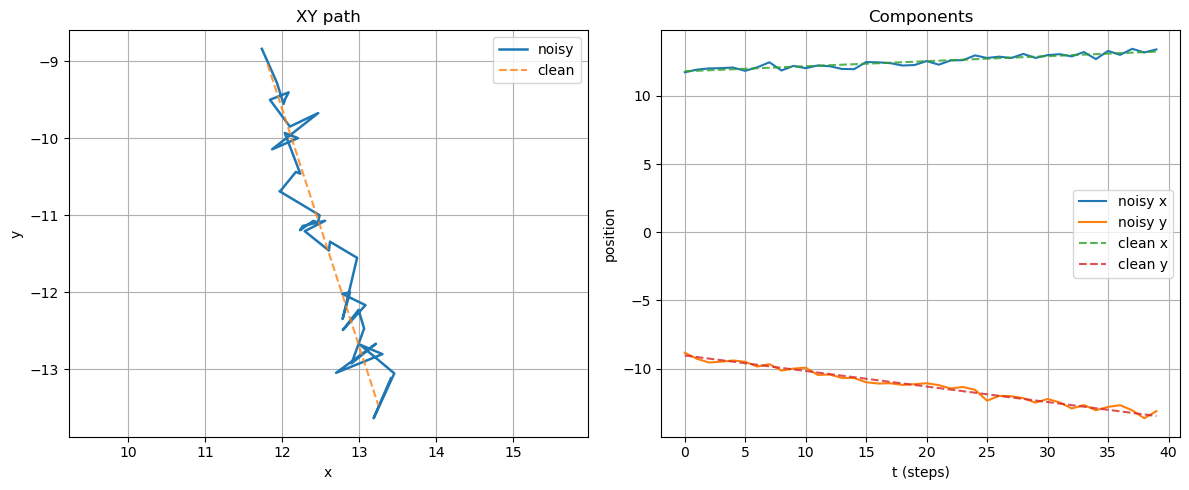

In [6]:
# 2D path, vx=3 m/s, vy=1 m/s, σ=0.2 m on both axes
NOISE = np.array([0.2, 0.2])
start = np.zeros(2)
v = [0.0, 1.0]
x0 = np.array([start[0], v[0], start[1], v[1]])
traj, clean = generate_cv_trajectory(T=40, dt=0.04, dim=2, v=None, x0=None,
                                     noise_std=NOISE, number_of_trajectories=2, seed=19)[0]

plot_trajectory_with_kf(traj, show_clean=clean)


F shape: (4, 4)
H shape: (2, 4)
Q shape: (4, 4)
P0 shape: (4, 4)
trans_offset shape: (4,)
R shape: (2, 2)
x0 shape: (4,)
{'mse': 0.0018729658940623867, 'per_axis': np.float64(0.0018729658940623867)}
21.187804468030215


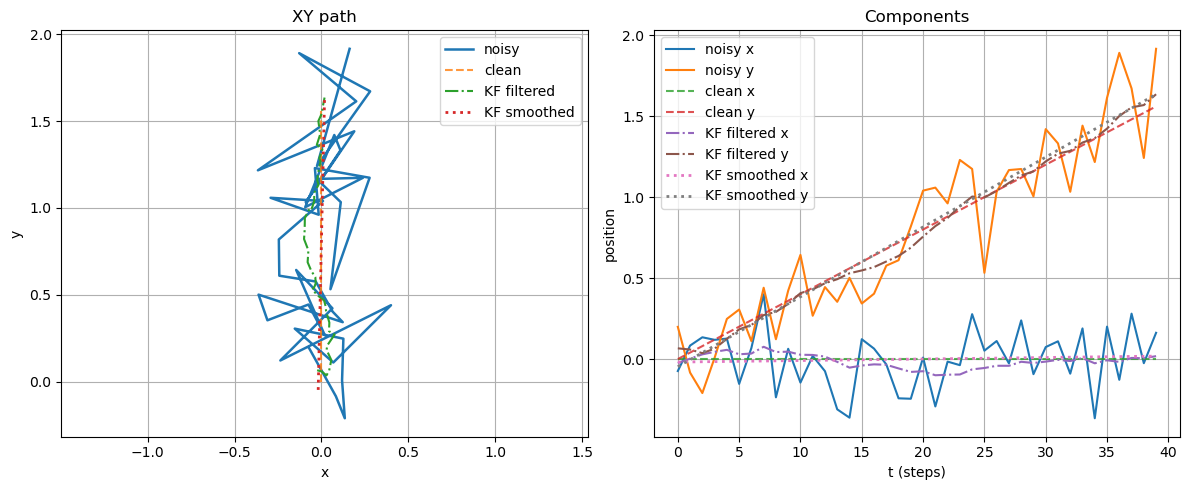

In [19]:
import numpy as np
from pykalman import KalmanFilter


# ---------------------------
# 1) Matrices (explicit, no kron)
# ---------------------------
def cv_matrices(dim: int, dt: float):
    """
    Constant-velocity model (positions only observed).
    State per axis: [pos, vel]; overall state: [x, vx, y, vy, (z, vz)]
    Returns F, H, Q (Q=0 here).
    """
    assert dim in (2, 3)
    if dim == 2:
        F = np.array([
            [1, dt, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, dt],
            [0, 0, 0, 1],
        ], dtype=float)
        H = np.array([
            [1, 0, 0, 0],  # measure x
            [0, 0, 1, 0],  # measure y
        ], dtype=float)
        Q = np.zeros((4, 4), dtype=float)  # no process noise
    else:  # dim == 3
        F = np.array([
            [1, dt, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, dt, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, dt],
            [0, 0, 0, 0, 0, 1],
        ], dtype=float)
        H = np.array([
            [1, 0, 0, 0, 0, 0],  # x
            [0, 0, 1, 0, 0, 0],  # y
            [0, 0, 0, 0, 1, 0],  # z
        ], dtype=float)
        Q = np.zeros((6, 6), dtype=float)  # no process noise
    return F, H, Q


def make_kf(F, H, Q, R, x0, P0):
    """Build the pykalman.KalmanFilter with your matrices."""
    return KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        transition_covariance=Q,
        observation_covariance=R,
        initial_state_mean=x0,
        initial_state_covariance=P0,
    )


# ---------------------------
# 2) Run the KF (+ optional EM on R)
# ---------------------------
def run_cv(kf: KalmanFilter, measurements: np.ndarray, em_iters: int = 0):
    """
    measurements: [T, dim] positions only.
    em_iters=0 -> just filter/smooth with given R.
    em_iters>0 -> first estimate R via EM (only observation_covariance), then filter/smooth.

    Returns dict with filtered/smoothed states + learned R (if EM used).
    """
    if em_iters > 0:
        kf = kf.em(measurements, n_iter=em_iters, em_vars=['observation_covariance'])

    xf, Pf = kf.filter(measurements)
    xs, Ps = kf.smooth(measurements)
    dim = measurements.shape[1]
    out = {
        "filtered_x": xf, "filtered_P": Pf,
        "smoothed_x": xs, "smoothed_P": Ps,
        "pos_filt": xf[:, :2 * dim:2],  # take every (pos,vel) pair's pos -> indices 0,2,(4)
        "vel_filt": xf[:, 1:2 * dim:2],  # corresponding velocities -> indices 1,3,(5)
        "pos_smooth": xs[:, :2 * dim:2],
        "vel_smooth": xs[:, 1:2 * dim:2],
    }
    if em_iters > 0:
        out["R_learned"] = kf.observation_covariance
    return out


F, H, Q = cv_matrices(2, 0.04)
P0 = np.eye(x0.shape[0]) * 1e-1
transition_offsets = np.zeros((F.shape[0]))
R = np.diag(NOISE)
print(f"F shape: {F.shape}")
print(f"H shape: {H.shape}")
print(f"Q shape: {Q.shape}")
print(f"P0 shape: {P0.shape}")
print(f"trans_offset shape: {transition_offsets.shape}")
print(f"R shape: {R.shape}")
print(f"x0 shape: {x0.shape}")

kf = KalmanFilter(
    transition_matrices=F,
    observation_matrices=H,
    transition_offsets=transition_offsets,
    transition_covariance=Q,
    observation_covariance=R,
    initial_state_mean=x0,
    initial_state_covariance=P0
)
#print(traj.shape)
#print(clean.shape)
# e.g., traj = generate_cv_trajectory(...), shape (T, dim)
xf, Pf = kf.filter(traj)
xs, Ps = kf.smooth(traj)

print(evaluation_tools.compute_mse(xf[:, [0, 2]], clean))
print(evaluation_tools.compute_nll(kf, traj))  #TODO: Need to understand how to interpret this
plot_trajectory_with_kf(traj, clean, kf_filt=xf[:, [0, 2]], kf_smooth=xs[:, [0, 2]])

# Evaluating KF for CV with random walk for velocity case #

We will create 4 different CV KFs. Each will train its own observation covariance matrix (R) and state covariance matrix (Q).
We expect to see that R is very similar in all cases, since we will generate the data with the same observation noise in order to simulate takind data from the same device.
We expect to see that Q is $[0, 0 \n
                            0, vel_{cov}]$
for every axis, when vel_cov is the velocity noise variance in that axis

In [4]:
import numpy as np
from pykalman import KalmanFilter
from KalmanFilter.good.cv_kalman_filter import CVKalmanFilter
from KalmanFilter.good.ca_kalman_filter import CAKalmanFilter
%load_ext autoreload
%autoreload 2

start = np.zeros(2)


In [38]:

NOISE = [2,2]
P0 = np.eye(4) * 1e2 #set high, since we don't know much about the initial state
transition_offsets = np.zeros((4)) #TODO: I dont know what this is

#Initialize 3 different instances of the CVKF
cvkf1 = CVKalmanFilter(dim=2, dt=0.04, P0=P0.copy(), transition_offsets=transition_offsets.copy(), process_noise=True)
cvkf2 = CVKalmanFilter(dim=2, dt=0.04, P0=P0.copy(), transition_offsets=transition_offsets.copy(), process_noise=True)
cvkf3 = CVKalmanFilter(dim=2, dt=0.04, P0=P0.copy(), transition_offsets=transition_offsets.copy(), process_noise=True)


em_iters = 2
#We wish to estimate only R and Q
vars_to_estimate = ['observation_covariance',
                    #'transition_matrices',
                    'transition_covariance',
                    #'initial_state_mean',
                    #'initial_state_covariance',
                    ]


print("Training the std 1:")
trajectories = generate_cv_with_micro_velocity_changes(T=400, dt=0.04, dim=2, v=None, x0=None, noise_std=NOISE,
                                                       number_of_trajectories=60, vel_change_std=[1,1], seed=14)
for traj, clean in trajectories:
    cvkf1.run_cv(traj, em_iters=em_iters, vars_to_estimate=vars_to_estimate)
print(f"learned observation cov: \n{cvkf1.kf.observation_covariance}")
print(f"learned transition cov: \n{cvkf1.kf.transition_covariance}")
#traj, clean = generate_cv_trajectory(T=200, dt=0.04, dim=2, v=None, x0=None,
#                              noise_std=NOISE, seed=15)[0]


print("Training the std 2:")
trajectories = generate_cv_with_micro_velocity_changes(T=400, dt=0.04, dim=2, v=None, x0=None, noise_std=NOISE,
                                                       number_of_trajectories=60, vel_change_std=[2,2], seed=14)
for traj, clean in trajectories:
    result = cvkf2.run_cv(traj, em_iters=em_iters, vars_to_estimate=vars_to_estimate)
print(f"learned observation cov: \n{cvkf2.kf.observation_covariance}")
print(f"learned transition cov: \n{cvkf2.kf.transition_covariance}")


print("Training the std 3:")
trajectories = generate_cv_with_micro_velocity_changes(T=400, dt=0.04, dim=2, v=None, x0=None, noise_std=NOISE,
                                                       number_of_trajectories=60, vel_change_std=[3,3], seed=14)
for traj, clean in trajectories:
    result = cvkf3.run_cv(traj, em_iters=em_iters, vars_to_estimate=vars_to_estimate)
print(f"learned observation cov: \n{cvkf3.kf.observation_covariance}")
print(f"learned transition cov: \n{cvkf3.kf.transition_covariance}")

print("Finished training CV Filters")

Training the std 1:
learned observation cov: 
[[4.43544573 0.        ]
 [0.         3.8243753 ]]
learned transition cov: 
[[0.         0.         0.         0.        ]
 [0.         0.9566066  0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         1.05076065]]
Training the std 2:
learned observation cov: 
[[4.42211824 0.        ]
 [0.         3.80896564]]
learned transition cov: 
[[0.         0.         0.         0.        ]
 [0.         3.63235685 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         4.19498052]]
Training the std 3:
learned observation cov: 
[[4.40399742 0.        ]
 [0.         3.77530411]]
learned transition cov: 
[[0.         0.         0.         0.        ]
 [0.         8.19047442 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         9.67850351]]
Finished training CV Filters


In [41]:
def run_test_and_update_cm(cm: np.ndarray, trajectories, true_label):
    for traj, clean in trajectories:
        em_iters = 0
        cvkf1.kf.initial_state_mean[0] = traj[0, 0]
        cvkf1.kf.initial_state_mean[1] = 0
        cvkf1.kf.initial_state_mean[2] = traj[0, 1]
        cvkf1.kf.initial_state_mean[3] = 0
        P0 = np.diag([1e-8, 1e2, 1e-8, 1e2])
        cvkf1.kf.initial_state_covariance = P0
        cvkf1_ll = cvkf1.kf.loglikelihood(traj)
        
        cvkf2.kf.initial_state_mean[0] = traj[0, 0]
        cvkf2.kf.initial_state_mean[1] = 0
        cvkf2.kf.initial_state_mean[2] = traj[0, 1]
        cvkf2.kf.initial_state_mean[3] = 0
        P0 = np.diag([1e-8, 1e2, 1e-8, 1e2])
        cvkf1.kf.initial_state_covariance = P0
        cvkf2_ll = cvkf2.kf.loglikelihood(traj)
        
        cvkf3.kf.initial_state_mean[0] = traj[0, 0]
        cvkf3.kf.initial_state_mean[1] = 0
        cvkf3.kf.initial_state_mean[2] = traj[0, 1]
        cvkf3.kf.initial_state_mean[3] = 0
        P0 = np.diag([1e-8, 1e2, 1e-8, 1e2])
        cvkf1.kf.initial_state_covariance = P0
        cvkf3_ll = cvkf3.kf.loglikelihood(traj)
        if (cvkf1_ll > cvkf2_ll and cvkf1_ll > cvkf3_ll):
            cm[true_label, 0] += 1
        if (cvkf2_ll > cvkf1_ll and cvkf2_ll > cvkf3_ll):
            cm[true_label, 1] += 1
        if (cvkf3_ll > cvkf1_ll and cvkf3_ll > cvkf2_ll):
            cm[true_label, 2] += 1
        print(cm)

cm = np.zeros((3,3)) #confusion matrix for this check

#testing 1-std traj
trajectories = generate_cv_with_micro_velocity_changes(T=400, dt=0.04, dim=2, v=None, x0=None,      number_of_trajectories=10,
                                                      noise_std=NOISE, vel_change_std=[1,1], seed=17)
#the true label in this case will be the velocity noise std - 1
run_test_and_update_cm(cm, trajectories, true_label=0)
trajectories = generate_cv_with_micro_velocity_changes(T=400, dt=0.04, dim=2, v=None, x0=None,      number_of_trajectories=10,
                                                      noise_std=NOISE, vel_change_std=[2,2], seed=17)
#the true label in this case will be the velocity noise std - 1
run_test_and_update_cm(cm, trajectories, true_label=1)
trajectories = generate_cv_with_micro_velocity_changes(T=400, dt=0.04, dim=2, v=None, x0=None,      number_of_trajectories=10,
                                                      noise_std=NOISE, vel_change_std=[3,3], seed=17)
#the true label in this case will be the velocity noise std - 1
run_test_and_update_cm(cm, trajectories, true_label=2)

print(cm)
#should be PERFECT classification. I suppose that near-perfect is also cool

[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[2. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[3. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[4. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[5. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[6. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[7. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[8. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[9. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[10.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  3.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  4.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  5.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  6.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  7.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  8.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  9.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0.  1.]]
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0.  2.]]
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0.  3.]]
[[10.  0.  0.]
 [ 0. 10

In [89]:
#OLD
import numpy as np

from pykalman import KalmanFilter


# ---------------------------
# 1) Matrices (explicit, no kron)
# ---------------------------
def cv_matrices(dim: int, dt: float):
    """
    Constant-velocity model (positions only observed).
    State per axis: [pos, vel]; overall state: [x, vx, y, vy, (z, vz)]
    Returns F, H, Q (Q=0 here).
    """
    assert dim in (2, 3)
    if dim == 2:
        F = np.array([
            [1, dt, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, dt],
            [0, 0, 0, 1],
        ], dtype=float)
        H = np.array([
            [1, 0, 0, 0],  # measure x
            [0, 0, 1, 0],  # measure y
        ], dtype=float)
        Q = np.zeros((4, 4), dtype=float)  # no process noise
    else:  # dim == 3
        F = np.array([
            [1, dt, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, dt, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, dt],
            [0, 0, 0, 0, 0, 1],
        ], dtype=float)
        H = np.array([
            [1, 0, 0, 0, 0, 0],  # x
            [0, 0, 1, 0, 0, 0],  # y
            [0, 0, 0, 0, 1, 0],  # z
        ], dtype=float)
        Q = np.zeros((6, 6), dtype=float)  # no process noise
    return F, H, Q


import numpy as np


# --- Keep R diagonal, bounded, PSD ---
def project_R_to_diag(R: np.ndarray, rmin=1e-6, rmax=10) -> np.ndarray:
    R = 0.5 * (R + R.T)
    d = np.clip(np.diag(R), rmin, rmax)
    return np.diag(d)


# --- Project Q to velocity random-walk per-axis blocks: [[0,0],[0,qv]] ---
def project_Q_to_velRW(Q: np.ndarray,
                       dim: int = 2,
                       tie_axes: bool = False,
                       q_bounds=(1e-8, 1e+3)) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns (Q_projected, qv_per_axis).
    """
    Q = 0.5 * (Q + Q.T)
    n = 2 * dim
    Qp = np.zeros((n, n), float)
    # read per-axis v-variance candidates
    qv_list = []
    for a in range(dim):
        i = 2 * a
        qv_list.append(max(0.0, float(Q[i + 1, i + 1])))
    if tie_axes:
        qv = float(np.clip(np.median(qv_list), *q_bounds))
        for a in range(dim):
            i = 2 * a
            Qp[i + 1, i + 1] = qv
        return Qp, np.array([qv] * dim)
    else:
        qv_arr = np.clip(np.array(qv_list), q_bounds[0], q_bounds[1])
        for a, qv in enumerate(qv_arr):
            i = 2 * a
            Qp[i + 1, i + 1] = float(qv)
        return Qp, qv_arr


# ---------------------------
# 2) Run the KF (+ optional EM on R)
# ---------------------------
def run_cv(kf: KalmanFilter, measurements: np.ndarray, em_iters: int = 0, estimate_v: bool = False):
    """
    measurements: [T, dim] positions only.
    em_iters=0 -> just filter/smooth with given R.
    em_iters>0 -> first estimate R via EM (only observation_covariance), then filter/smooth.

    Returns dict with filtered/smoothed states + learned R (if EM used).
    """
    if em_iters > 0:
        for i in range(em_iters):
            #kf = kf.em(measurements, n_iter=em_iters, em_vars=['observation_covariance'])
            if estimate_v:
                vx0_hat = (measurements[1, 0] - measurements[0, 0]) / 0.04
                vy0_hat = (measurements[1, 1] - measurements[0, 1]) / 0.04
            else:
                vx0_hat = 0
                vy0_hat = 0
            x0 = np.array([measurements[0, 0], 0, measurements[0, 1], 0])
            kf.initial_state_mean = x0
            kf = kf.em(measurements, n_iter=1, em_vars=['observation_covariance',
                                                        #'transition_matrices',
                                                        'transition_covariance',
                                                        #'initial_state_mean',
                                                        #'initial_state_covariance',
                                                        ])
            kf.observation_covariance = project_R_to_diag(kf.observation_covariance)
            kf.transition_covariance = project_Q_to_velRW(kf.transition_covariance)[0]

    xf, Pf = kf.filter(measurements)
    xs, Ps = kf.smooth(measurements)
    dim = measurements.shape[1]
    out = {
        "filtered_x": xf, "filtered_P": Pf,
        "smoothed_x": xs, "smoothed_P": Ps,
        "pos_filt": xf[:, :2 * dim:2],  # take every (pos,vel) pair's pos -> indices 0,2,(4)
        "vel_filt": xf[:, 1:2 * dim:2],  # corresponding velocities -> indices 1,3,(5)
        "pos_smooth": xs[:, :2 * dim:2],
        "vel_smooth": xs[:, 1:2 * dim:2],
    }
    if em_iters > 0:
        out["R_learned"] = kf.observation_covariance
        out["F_learned"] = kf.transition_matrices
    return out


F, H, Q = cv_matrices(2, 0.04)
Q = np.eye(4, 4) * 1e1
#Q = np.zeros((4,4), float)
#qv = 1e-2                    # try 1e-5 … 1e-3
#Q[1,1] = qv; Q[3,3] = qv     # process variance on velocities only


#P0 = np.diag([1e-8, 1/3, 1e-8, 1/3])
P0 = np.eye(4) * 1e2
#P0 = np.zeros((x0.shape[0],x0.shape[0]))
transition_offsets = np.zeros((F.shape[0]))
R = np.diag(NOISE ** 2)

#Initial Estimation for R
#R0 = np.diag(np.maximum(np.var(traj - clean, axis=0), 1e-6))
#print(f"F shape: {F.shape}")
#print(f"H shape: {H.shape}")
#print(f"Q shape: {Q.shape}")
#print(f"P0 shape: {P0.shape}")
#print(f"trans_offset shape: {transition_offsets.shape}")
#print(f"R shape: {R.shape}")
#print(f"x0 shape: {x0.shape}")

kf = KalmanFilter(
    transition_matrices=F,
    observation_matrices=H,
    transition_offsets=transition_offsets,
    transition_covariance=Q,  #Process noise
    #    observation_covariance=R,
    initial_state_mean=x0,
    initial_state_covariance=P0,
)
print(F)
#print(clean.shape)
# e.g., traj = generate_cv_trajectory(...), shape (T, dim)
trajectories = generate_cv_with_micro_velocity_changes(T=200, dt=0.04, dim=3, v=None, x0=None, noise_std=NOISE,
                                                       number_of_trajectories=40, accel_std=[1, 1], seed=14)

em_iters = 3
for traj, clean in trajectories:
    result = run_cv(kf, traj, em_iters=em_iters)
    if em_iters:
        pass
        #print(f"learned observation covariance: \n{result['R_learned']}")
        #print(f"learned transition matrix: \n{result['F_learned']}")
    #print(kf.transition_matrices)
    #plot_trajectory_with_kf(traj, kf_filt=result["pos_filt"])#, kf_smooth=result["pos_smooth"])

print(f"learned observation cov: \n{kf.observation_covariance}")
print(f"learned transition cov: \n{kf.transition_covariance}")
#traj, clean = generate_cv_trajectory(T=200, dt=0.04, dim=2, v=None, x0=None,
#                              noise_std=NOISE, seed=15)[0]
traj, clean = generate_cv_with_micro_velocity_changes(T=200, dt=0.04, dim=2, v=None, x0=None,
                                                      noise_std=NOISE, accel_std=[1, 1], seed=15)[0]
em_iters = 0
kf.initial_state_mean[0] = traj[0, 0]
kf.initial_state_mean[2] = traj[0, 1]

result = run_cv(kf, traj, em_iters=em_iters)
plot_trajectory_with_kf(traj, show_clean=clean, kf_filt=result["pos_filt"])  #, kf_smooth=result["pos_smooth"])
plot_trajectory_with_kf(result["pos_filt"])

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

# CAKalmanFilter New Development #

Training the CA base


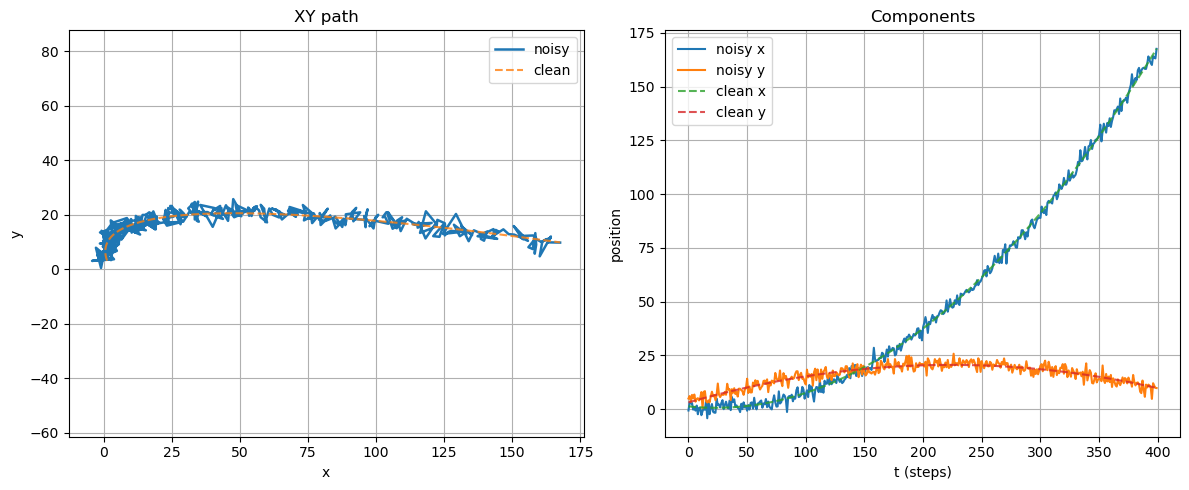

learned observation cov: 
[[3.9656202  0.        ]
 [0.         3.86909592]]
learned transition cov: 
[[8.27559198e-09 5.17224499e-07 1.72408166e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.17224499e-07 3.44816332e-05 1.29306125e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.72408166e-05 1.29306125e-03 6.46530623e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.27559198e-09
  5.17224499e-07 1.72408166e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.17224499e-07
  3.44816332e-05 1.29306125e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.72408166e-05
  1.29306125e-03 6.46530623e-02]]
Training the CA different noise
learned observation cov: 
[[10.  0.]
 [ 0. 10.]]
learned transition cov: 
[[1.79364657e-08 1.12102911e-06 3.73676369e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.12102911e-06 7.47352737e-05 2.80257276e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.73676369e-05 2.80257276e-03

In [22]:
import numpy as np
NOISE = [2,2]
P0 = np.eye(4) * 1e2 #set high, since we don't know much about the initial state
transition_offsets = np.zeros((4)) #TODO: I dont know what this is
ca_P0 = np.eye(6) * 1e2 #set high, since we don't know much about the initial state
ca_transition_offsets = np.zeros((6)) #TODO: I dont know what this is

#Initialize 3 different instances of the CVKF
cakf1 = CAKalmanFilter(dim=2, dt=0.04, P0=ca_P0.copy(), transition_offsets=ca_transition_offsets.copy(), process_noise=True)
cakf2 = CAKalmanFilter(dim=2, dt=0.04, P0=ca_P0.copy(), transition_offsets=ca_transition_offsets.copy(), process_noise=True)
cvkf = CVKalmanFilter(dim=2, dt=0.04, P0=P0.copy(), transition_offsets=transition_offsets.copy(), process_noise=True)


em_iters = 2
#We wish to estimate only R and Q
vars_to_estimate = ['observation_covariance',
                    #'transition_matrices',
                    'transition_covariance',
                    #'initial_state_mean',
                    #'initial_state_covariance',
                    ]


print("Training the CA base")
trajectories = generate_ca_trajectory(T=400, dt=0.04, dim=2, measurement_noise_std=NOISE,
                                                       number_of_trajectories=60, seed=8)
plot_trajectory_with_kf(trajectories[0][0], trajectories[0][1])

for traj, clean in trajectories:
    cakf1.run_cv(traj, em_iters=em_iters, vars_to_estimate=vars_to_estimate)
print(f"learned observation cov: \n{cakf1.kf.observation_covariance}")
print(f"learned transition cov: \n{cakf1.kf.transition_covariance}")
#traj, clean = generate_cv_trajectory(T=200, dt=0.04, dim=2, v=None, x0=None,
#                              noise_std=NOISE, seed=15)[0]


print("Training the CA different noise")
trajectories = generate_cv_with_micro_velocity_changes(T=400, dt=0.04, dim=2, v=None, x0=None, noise_std=[5,5],
                                                       number_of_trajectories=60, seed=14)
for traj, clean in trajectories:
    result = cakf2.run_cv(traj, em_iters=em_iters, vars_to_estimate=vars_to_estimate)
print(f"learned observation cov: \n{cakf2.kf.observation_covariance}")
print(f"learned transition cov: \n{cakf2.kf.transition_covariance}")


print("Training the std 3:")
trajectories = generate_cv_with_micro_velocity_changes(T=400, dt=0.04, dim=2, v=None, x0=None, noise_std=NOISE,
                                                       number_of_trajectories=60, vel_change_std=[3,3], seed=14)
for traj, clean in trajectories:
    result = cvkf.run_cv(traj, em_iters=em_iters, vars_to_estimate=vars_to_estimate)
print(f"learned observation cov: \n{cvkf.kf.observation_covariance}")
print(f"learned transition cov: \n{cvkf.kf.transition_covariance}")

print("Finished training CV Filters")

In [24]:
def run_test_and_update_cm(cm: np.ndarray, trajectories, true_label):
    for traj, clean in trajectories:
        em_iters = 0
        cakf1.kf.initial_state_mean[0] = traj[0, 0]
        cakf1.kf.initial_state_mean[1] = 0
        cakf1.kf.initial_state_mean[2] = traj[0, 1]
        cakf1.kf.initial_state_mean[3] = 0
        cakf1_ll = cakf1.kf.loglikelihood(traj)
        
        cakf2.kf.initial_state_mean[0] = traj[0, 0]
        cakf2.kf.initial_state_mean[1] = 0
        cakf2.kf.initial_state_mean[2] = traj[0, 1]
        cakf2.kf.initial_state_mean[3] = 0
        cakf2_ll = cakf2.kf.loglikelihood(traj)
        
        cvkf.kf.initial_state_mean[0] = traj[0, 0]
        cvkf.kf.initial_state_mean[1] = 0
        cvkf.kf.initial_state_mean[2] = traj[0, 1]
        cvkf.kf.initial_state_mean[3] = 0
        cvkf_ll = cvkf.kf.loglikelihood(traj)
        if (cakf1_ll > cakf2_ll and cakf1_ll > cvkf_ll):
            cm[true_label, 0] += 1
        if (cakf2_ll > cakf1_ll and cakf2_ll > cvkf_ll):
            cm[true_label, 1] += 1
        if (cvkf_ll > cakf1_ll and cvkf_ll > cakf2_ll):
            cm[true_label, 2] += 1
        print(cm)

cm = np.zeros((3,3)) #confusion matrix for this check

#testing 1-std traj
trajectories = generate_ca_trajectory(T=400, dt=0.04, dim=2, measurement_noise_std=NOISE,
                                                       number_of_trajectories=10, seed=10)
#the true label in this case will be the velocity noise std - 1
run_test_and_update_cm(cm, trajectories, true_label=0)
trajectories = generate_cv_with_micro_velocity_changes(T=400, dt=0.04, dim=2, v=None, x0=None, noise_std=[5,5],
                                                       number_of_trajectories=10, seed=10)
#the true label in this case will be the velocity noise std - 1
run_test_and_update_cm(cm, trajectories, true_label=1)
trajectories = generate_cv_with_micro_velocity_changes(T=400, dt=0.04, dim=2, v=None, x0=None, noise_std=NOISE,
                                                       number_of_trajectories=10, vel_change_std=[3,3], seed=10)
#the true label in this case will be the velocity noise std - 1
run_test_and_update_cm(cm, trajectories, true_label=2)

print(cm)

[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[2. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[3. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[4. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[5. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[6. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[7. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[8. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[9. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[10.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  3.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  4.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  5.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  6.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  7.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  8.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0.  9.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0.  0.]]
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0.  1.]]
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0.  2.]]
[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0.  3.]]
[[10.  0.  0.]
 [ 0. 10

KeyboardInterrupt: 

## Testing on Real Walaris Data #

In [28]:
import os
import json
from KalmanFilter.good.cv_kalman_filter import CVKalmanFilter

C = 1000

def load_datasets(name):
    folder_to_name = {"bird": r"C:\workspace\DL\UAV_classification\track_data\bird",
                      "uav": r"C:\workspace\DL\UAV_classification\track_data\uav",
                      "airplane": r"C:\workspace\DL\UAV_classification\track_data\airplane",
                      "static-object": r"C:\workspace\DL\UAV_classification\track_data\static-object"
                      }
    folder = folder_to_name[name]
    file_paths = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    
    datasets = []
    for path in file_paths:
    
        data = json.load(open(path))
        data = data['track_data']
        
        positions = np.array([d["position_xyz"] for d in data])   # shape (N, 3)
        timestamps = np.array([d["timestamp"] for d in data])    # shape (N,)
        
        datasets.append(positions)
    return datasets

birds = load_datasets("bird")
airplanes = load_datasets("airplane")
uav = load_datasets("uav")


In [29]:
def compute_scalers(seqs):
    Z = np.vstack(seqs)
    med = np.median(Z, axis=0)
    mad = np.median(np.abs(Z - med), axis=0)
    s = np.clip(1.4826*mad, 1e-6, None)   # robust per-axis scale
    return s

def scale_seqs(seqs, s): return [z / s for z in seqs]

s = compute_scalers(birds)
birds = scale_seqs(birds, s)

s = compute_scalers(birds)
airplanes = scale_seqs(airplanes, s)

s = compute_scalers(birds)
uav = scale_seqs(uav, s)

In [31]:
#Initialize 3 different instances of the CVKF
P0 = np.eye(6) * 1e2
transition_offsets = np.zeros(6)
cakf_observation_train = CAKalmanFilter(dim=2, dt=0.04, P0=P0.copy(), transition_offsets=transition_offsets.copy())
cakf_bird = CAKalmanFilter(dim=2, dt=0.04, P0=P0.copy(), transition_offsets=transition_offsets.copy(), process_noise=True)
cakf_airplane = CAKalmanFilter(dim=2, dt=0.04, P0=P0.copy(), transition_offsets=transition_offsets.copy(), process_noise=True)
cakf_uav = CAKalmanFilter(dim=2, dt=0.04, P0=P0.copy(), transition_offsets=transition_offsets.copy(), process_noise=True)

In [35]:
import random
em_iters = 12
#We wish to estimate only R and Q
vars_to_estimate = ['observation_covariance',
                    #'transition_matrices',
                    #'transition_covariance',
                    #'initial_state_mean',
                    #'initial_state_covariance',
                    ]

all_train = birds[:10] + airplanes[:10] + uav[:10]
assert len(all_train) == 30
random.shuffle(all_train)

for traj in all_train:
    traj = traj[:, [0,1]]
    traj = traj[:min(200, traj.shape[0])] * C
    cakf_observation_train.run_cv(traj, em_iters=em_iters, vars_to_estimate=vars_to_estimate)
print(f"learned observation cov: \n{cakf_observation_train.kf.observation_covariance}")

cakf_bird.kf.observation_covariance = cakf_observation_train.kf.observation_covariance.copy()
cakf_airplane.kf.observation_covariance = cakf_observation_train.kf.observation_covariance.copy()
cakf_uav.kf.observation_covariance = cakf_observation_train.kf.observation_covariance.copy()

em_iters = 12
#We wish to estimate only R and Q
vars_to_estimate = [#'observation_covariance',
                    #'transition_matrices',
                    'transition_covariance',
                    #'initial_state_mean',
                    #'initial_state_covariance',
                    ]


print("Training the birds:")
for traj in birds[:10]:
    traj = traj[:min(70, traj.shape[0]), [0,1]]
    traj = traj * C / 10
    cakf_bird.run_cv(traj, em_iters=em_iters, vars_to_estimate=vars_to_estimate)
print(f"learned observation cov: \n{cakf_bird.kf.observation_covariance}")
print(f"learned transition cov: \n{cakf_bird.kf.transition_covariance}")
#traj, clean = generate_cv_trajectory(T=200, dt=0.04, dim=2, v=None, x0=None,
#                              noise_std=NOISE, seed=15)[0]


print("Training the airplane:")
for traj in airplanes[:10]:
    traj = traj[:min(200, traj.shape[0]), [0,1]]
    traj = traj * C / 10

    cakf_airplane.run_cv(traj, em_iters=em_iters, vars_to_estimate=vars_to_estimate)
print(f"learned observation cov: \n{cakf_airplane.kf.observation_covariance}")
print(f"learned transition cov: \n{cakf_airplane.kf.transition_covariance}")


print("Training the uav:")
for traj in uav[:10]:
    traj = traj[:min(200, traj.shape[0]), [0,1]]
    traj = traj * C / 10
    cakf_uav.run_cv(traj, em_iters=em_iters, vars_to_estimate=vars_to_estimate)
print(f"learned observation cov: \n{cakf_uav.kf.observation_covariance}")
print(f"learned transition cov: \n{cakf_uav.kf.transition_covariance}")

print("Finished training CV Filters")

learned observation cov: 
[[0.21519947 0.        ]
 [0.         0.00071615]]
Training the birds:
learned observation cov: 
[[0.21519947 0.        ]
 [0.         0.00071615]]
learned transition cov: 
[[5.02984849e-08 3.14365531e-06 1.04788510e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.14365531e-06 2.09577021e-04 7.85913827e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.04788510e-04 7.85913827e-03 3.92956914e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.02984849e-08
  3.14365531e-06 1.04788510e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.14365531e-06
  2.09577021e-04 7.85913827e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.04788510e-04
  7.85913827e-03 3.92956914e-01]]
Training the airplane:
learned observation cov: 
[[0.21519947 0.        ]
 [0.         0.00071615]]
learned transition cov: 
[[5.01279363e-08 3.13299602e-06 1.04433201e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.132996

In [37]:
def run_test_and_update_cm(cm: np.ndarray, trajectories, true_label):
    for traj in trajectories:
        traj = traj[:, [0,1]]
        traj = traj * C / 10
        em_iters = 0
        cakf_bird.kf.initial_state_mean[0] = traj[0, 0]
        cakf_bird.kf.initial_state_mean[1] = 0
        cakf_bird.kf.initial_state_mean[2] = traj[0, 1]
        cakf_bird.kf.initial_state_mean[3] = 0
        #cakf_bird.kf.initial_state_mean[4] = traj[0, 2]
        #cakf_bird.kf.initial_state_mean[5] = 0

        cakf_bird_ll = cakf_bird.kf.loglikelihood(traj)
        #print(cvkf_bird_ll)
        #result = cvkf_bird.run_cv(traj, em_iters=em_iters)
        #plot_trajectory_with_kf(traj, kf_filt=result["pos_filt"])  #, kf_smooth=result["pos_smooth"])

        
        cakf_airplane.kf.initial_state_mean[0] = traj[0, 0]
        cakf_airplane.kf.initial_state_mean[1] = 0
        cakf_airplane.kf.initial_state_mean[2] = traj[0, 1]
        cakf_airplane.kf.initial_state_mean[3] = 0
        #cakf_airplane.kf.initial_state_mean[4] = traj[0, 2]
        #cakf_airplane.kf.initial_state_mean[5] = 0

        cakf_airplane_ll = cakf_airplane.kf.loglikelihood(traj)
        #print(cvkf_airplane_ll)
        #result = cvkf_airplane.run_cv(traj, em_iters=em_iters)
        #plot_trajectory_with_kf(traj, kf_filt=result["pos_filt"])  #,
        
        cakf_uav.kf.initial_state_mean[0] = traj[0, 0]
        cakf_uav.kf.initial_state_mean[1] = 0
        cakf_uav.kf.initial_state_mean[2] = traj[0, 1]
        cakf_uav.kf.initial_state_mean[3] = 0
        #cakf_uav.kf.initial_state_mean[4] = traj[0, 2]
        #cakf_uav.kf.initial_state_mean[5] = 0
        cakf_uav_ll = cakf_uav.kf.loglikelihood(traj)
        #print(cvkf_uav_ll)
        #result = cvkf_uav.run_cv(traj, em_iters=em_iters)
        #plot_trajectory_with_kf(traj, kf_filt=result["pos_filt"])  #, 

        
        if (cakf_bird_ll > cakf_airplane_ll and cakf_bird_ll > cakf_uav_ll):
            cm[true_label, 0] += 1
        if (cakf_airplane_ll > cakf_bird_ll and cakf_airplane_ll > cakf_uav_ll):
            cm[true_label, 1] += 1
        if (cakf_uav_ll > cakf_bird_ll and cakf_uav_ll > cakf_airplane_ll):
            cm[true_label, 2] += 1
        print(cm)


cm = np.zeros((3,3)) #confusion matrix for this check
run_test_and_update_cm(cm, birds[8:], true_label=0)
run_test_and_update_cm(cm, airplanes[10:15], true_label=1)
run_test_and_update_cm(cm, uav[10:15], true_label=2)

print(cm)

[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 2. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[2. 2. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[3. 2. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[3. 2. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]
[[3. 2. 0.]
 [1. 1. 0.]
 [0. 0. 0.]]
[[3. 2. 0.]
 [2. 1. 0.]
 [0. 0. 0.]]
[[3. 2. 0.]
 [3. 1. 0.]
 [0. 0. 0.]]
[[3. 2. 0.]
 [4. 1. 0.]
 [0. 0. 0.]]
[[3. 2. 0.]
 [4. 1. 0.]
 [0. 1. 0.]]
[[3. 2. 0.]
 [4. 1. 0.]
 [0. 2. 0.]]
[[3. 2. 0.]
 [4. 1. 0.]
 [0. 2. 1.]]


KeyboardInterrupt: 

# Constant Acceleration #

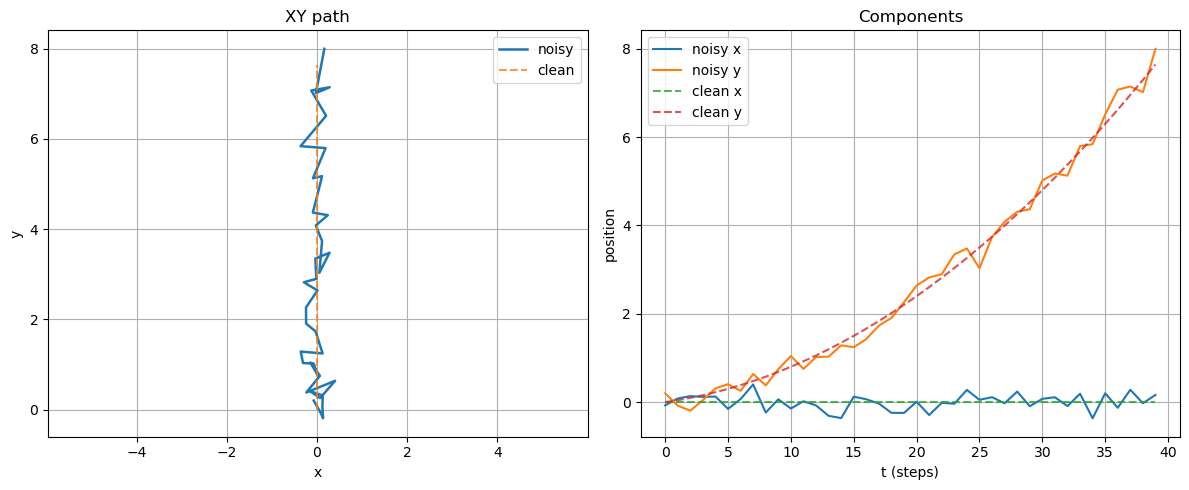

In [42]:
NOISE = np.array([0.2, 0.2])
start = np.zeros(2)
v = [0.0, 1.0]
a = [0.0, 5.0]
x0 = np.array([start[0], v[0], start[1], v[1]])
traj, clean = generate_ca_trajectory(T=40, dt=0.04, dim=2, a=a, v0=v, x0=start,
                                     measurement_noise_std=NOISE, seed=19)

plot_trajectory_with_kf(traj, show_clean=clean)


{'mse': 0.15867161338893446, 'per_axis': np.float64(0.15867161338893446)}
227.72431603902012


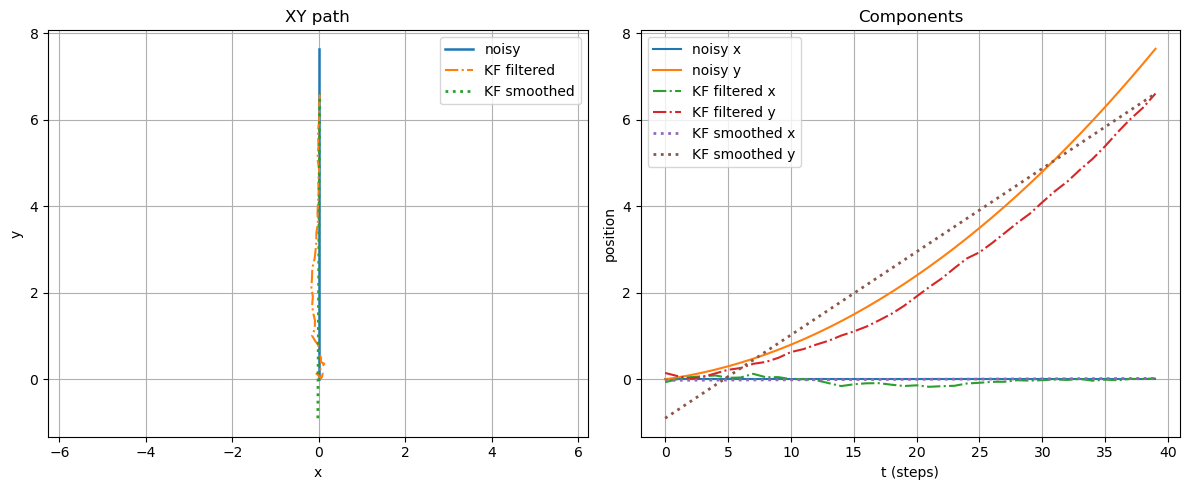

In [43]:
xf, Pf = kf.filter(traj)
xs, Ps = kf.smooth(traj)

print(evaluation_tools.compute_mse(xf[:, [0, 2]], clean))
print(evaluation_tools.compute_nll(kf, traj))  #TODO: Need to understand how to interpret this
plot_trajectory_with_kf(clean, kf_filt=xf[:, [0, 2]], kf_smooth=xs[:, [0, 2]])
